In [1]:
import tsfresh
import feature_engine
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/home/mali7319/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
train_X = pd.read_csv("X_train.csv")
test_X = pd.read_csv("X_test.csv")
train_y = pd.read_csv("y_train.csv")

In [3]:
train_X.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
train_X.shape

(487680, 13)

In [5]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 487680 non-null  object 
 1   series_id              487680 non-null  int64  
 2   measurement_number     487680 non-null  int64  
 3   orientation_X          487680 non-null  float64
 4   orientation_Y          487680 non-null  float64
 5   orientation_Z          487680 non-null  float64
 6   orientation_W          487680 non-null  float64
 7   angular_velocity_X     487680 non-null  float64
 8   angular_velocity_Y     487680 non-null  float64
 9   angular_velocity_Z     487680 non-null  float64
 10  linear_acceleration_X  487680 non-null  float64
 11  linear_acceleration_Y  487680 non-null  float64
 12  linear_acceleration_Z  487680 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [6]:
train_X.describe().T

,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792262,36.79700


In [7]:
variables = list(train_X.columns)[3:]

In [8]:
train_y.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [9]:
train_y["series_id"].value_counts()

series_id
0       1
2544    1
2532    1
2533    1
2534    1
       ..
1274    1
1275    1
1276    1
1277    1
3809    1
Name: count, Length: 3810, dtype: int64

In [10]:
train_X["series_id"].value_counts()

series_id
0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: count, Length: 3810, dtype: int64

In [11]:
train_X[120:130]

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
120,0_120,0,120,-0.75933,-0.63321,-0.105010,-0.10695,0.019534,-0.039577,0.020605,-0.48942,1.40630,-11.6190
121,0_121,0,121,-0.75938,-0.63318,-0.104830,-0.10690,0.078623,-0.067751,0.025602,-1.40710,0.99199,-10.9830
122,0_122,0,122,-0.75942,-0.63317,-0.104720,-0.10682,0.105170,-0.032534,0.022191,-0.32867,0.84479,-9.4067
123,0_123,0,123,-0.75943,-0.63316,-0.104700,-0.10677,0.041741,0.012857,0.016053,-0.80827,1.79890,-6.8687
124,0_124,0,124,-0.75945,-0.63313,-0.104730,-0.10683,-0.052041,-0.014752,0.021632,-0.36055,2.35620,-6.8926
125,0_125,0,125,-0.75949,-0.63309,-0.104670,-0.10690,-0.083083,-0.044480,0.031726,-0.98193,0.97328,-9.9795
126,0_126,0,126,-0.75950,-0.63307,-0.104640,-0.10693,-0.001305,-0.031012,0.017241,-0.72591,0.34931,-11.9770
127,0_127,0,127,-0.75953,-0.63306,-0.104610,-0.10684,0.073856,0.020353,0.018466,-0.53426,0.80346,-10.6970
128,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503
129,1_1,1,1,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.49905,2.97620,-5.4953


In [12]:
merged_df = pd.merge(train_X, train_y, on="series_id")

In [13]:
merged_df[120:130]

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
120,0_120,0,120,-0.75933,-0.63321,-0.105010,-0.10695,0.019534,-0.039577,0.020605,-0.48942,1.40630,-11.6190,13,fine_concrete
121,0_121,0,121,-0.75938,-0.63318,-0.104830,-0.10690,0.078623,-0.067751,0.025602,-1.40710,0.99199,-10.9830,13,fine_concrete
122,0_122,0,122,-0.75942,-0.63317,-0.104720,-0.10682,0.105170,-0.032534,0.022191,-0.32867,0.84479,-9.4067,13,fine_concrete
123,0_123,0,123,-0.75943,-0.63316,-0.104700,-0.10677,0.041741,0.012857,0.016053,-0.80827,1.79890,-6.8687,13,fine_concrete
124,0_124,0,124,-0.75945,-0.63313,-0.104730,-0.10683,-0.052041,-0.014752,0.021632,-0.36055,2.35620,-6.8926,13,fine_concrete
125,0_125,0,125,-0.75949,-0.63309,-0.104670,-0.10690,-0.083083,-0.044480,0.031726,-0.98193,0.97328,-9.9795,13,fine_concrete
126,0_126,0,126,-0.75950,-0.63307,-0.104640,-0.10693,-0.001305,-0.031012,0.017241,-0.72591,0.34931,-11.9770,13,fine_concrete
127,0_127,0,127,-0.75953,-0.63306,-0.104610,-0.10684,0.073856,0.020353,0.018466,-0.53426,0.80346,-10.6970,13,fine_concrete
128,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503,31,concrete
129,1_1,1,1,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.49905,2.97620,-5.4953,31,concrete


In [14]:
merged_df[:128].surface.value_counts()

surface
fine_concrete    128
Name: count, dtype: int64

In [15]:
merged_df["surface"].value_counts()

surface
concrete                  99712
soft_pvc                  93696
wood                      77696
tiled                     65792
fine_concrete             46464
hard_tiles_large_space    39424
soft_tiles                38016
carpet                    24192
hard_tiles                 2688
Name: count, dtype: int64

In [16]:
def split_data(data, momentum, n=5):

    data_dict = {}
    for surface in list(data["surface"].value_counts().index):
        data_dict[surface] = []
        
    for i in range(0, len(data), 128):
        partial_data = data[i:i+128][variables]
        partial_label = list(data[i:i+128]["surface"].values)[0]
        if momentum:
            partial_data = partial_data.rolling(n).apply(np.prod)[n-1:]
        data_dict[partial_label].append(partial_data)

    return data_dict

In [17]:
main_data_dict = split_data(merged_df, False)

In [18]:
class_dist = {}
example_total = 0
for k, v in main_data_dict.items():
    class_dist[k] = len(v)
    print(f"Surface Type: {k}   =>  Number of Examples: {len(v)}")
    example_total += len(v)
print(f"Total Number of Examples: {example_total}")

Surface Type: concrete   =>  Number of Examples: 779
Surface Type: soft_pvc   =>  Number of Examples: 732
Surface Type: wood   =>  Number of Examples: 607
Surface Type: tiled   =>  Number of Examples: 514
Surface Type: fine_concrete   =>  Number of Examples: 363
Surface Type: hard_tiles_large_space   =>  Number of Examples: 308
Surface Type: soft_tiles   =>  Number of Examples: 297
Surface Type: carpet   =>  Number of Examples: 189
Surface Type: hard_tiles   =>  Number of Examples: 21
Total Number of Examples: 3810


<Axes: >

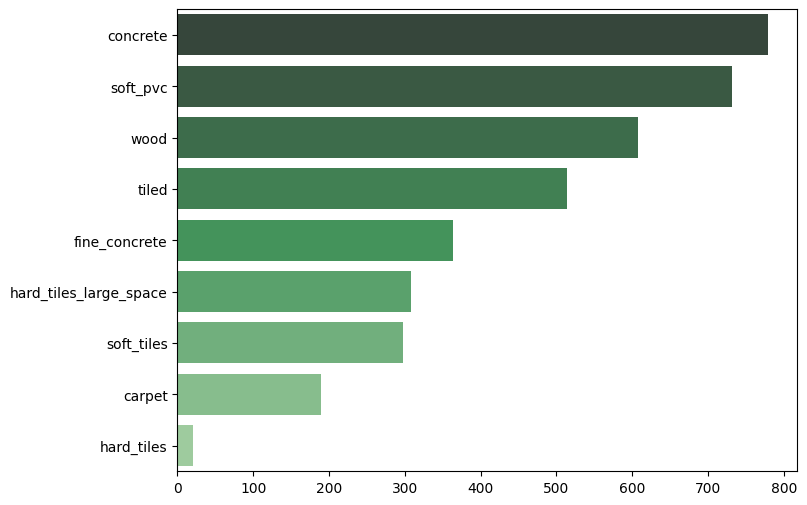

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(x=class_dist.values(), y=class_dist.keys(), palette=sns.color_palette("Greens_d", len(class_dist))[::-1])

In [20]:
merged_df[128:128*2][variables+["surface"]].reset_index()

,index,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,surface
0,128,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.184800,2.25260,-8.9503,concrete
1,129,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.499050,2.97620,-5.4953,concrete
2,130,-0.95889,0.24076,0.030807,-0.14702,-0.073197,0.003959,-0.023384,0.748270,1.68030,-7.3061,concrete
3,131,-0.95888,0.24076,0.030742,-0.14712,-0.064979,0.068265,0.018673,1.840800,0.22349,-11.4910,concrete
4,132,-0.95888,0.24079,0.030707,-0.14702,0.077929,0.005519,0.022119,-0.496670,-0.92942,-12.2980,concrete
...,...,...,...,...,...,...,...,...,...,...,...,...
123,251,-0.95861,0.24232,0.032148,-0.14601,0.088261,-0.042589,-0.054829,-2.026700,2.20210,-6.0248,concrete
124,252,-0.95860,0.24230,0.032170,-0.14607,-0.052245,-0.002384,-0.015946,0.564960,3.36600,-5.8875,concrete
125,253,-0.95863,0.24225,0.032118,-0.14599,-0.035939,0.016925,-0.008124,-3.193400,-0.49307,-9.8661,concrete
126,254,-0.95864,0.24223,0.032065,-0.14594,0.044449,0.033863,-0.007100,1.526200,2.32720,-10.3900,concrete


In [31]:
def get_features(data):
    df_surface = pd.DataFrame()
    for i in range(0, len(data), 128):
        new_df = data[i:i+128][variables+["surface"]].reset_index()
        df_features = tsfresh.extract_features(new_df, column_id='surface', column_sort="index", disable_progressbar=True,
                                               default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
        df_surface = pd.concat([df_surface, df_features])
        
    return df_surface#.dropna(axis=1).reset_index().rename(columns={'index': "surface"})

In [32]:
#tsf_df = get_features(merged_df)

In [33]:
#tsf_df.to_csv("tsf_data.csv")

In [34]:
tsf_df = pd.read_csv("tsf_data.csv").rename(columns={"Unnamed: 0":"surface"})

In [35]:
tsf_df.head()

,surface,orientation_Y__variance_larger_than_standard_deviation,orientation_Y__has_duplicate_max,orientation_Y__has_duplicate_min,orientation_Y__has_duplicate,orientation_Y__sum_values,orientation_Y__abs_energy,orientation_Y__mean_abs_change,orientation_Y__mean_change,orientation_Y__mean_second_derivative_central,...,linear_acceleration_Z__fourier_entropy__bins_5,linear_acceleration_Z__fourier_entropy__bins_10,linear_acceleration_Z__fourier_entropy__bins_100,linear_acceleration_Z__permutation_entropy__dimension_3__tau_1,linear_acceleration_Z__permutation_entropy__dimension_4__tau_1,linear_acceleration_Z__permutation_entropy__dimension_5__tau_1,linear_acceleration_Z__permutation_entropy__dimension_6__tau_1,linear_acceleration_Z__permutation_entropy__dimension_7__tau_1,linear_acceleration_Z__query_similarity_count__query_None__threshold_0.0,linear_acceleration_Z__mean_n_absolute_max__number_of_maxima_7
0,fine_concrete,0.0,0.0,1.0,1.0,-81.15298,51.451639,0.000018,0.000010,4.405647e-19,...,0.535582,0.963295,2.585272,1.626752,2.689212,3.693933,4.430252,4.704539,NaN,11.656714
1,concrete,0.0,1.0,0.0,1.0,30.95897,7.487983,0.000070,0.000012,7.936508e-08,...,0.158734,0.387927,1.724173,1.660974,2.667509,3.615909,4.254884,4.597982,NaN,13.967714
2,concrete,0.0,0.0,0.0,1.0,-108.30988,91.648751,0.000024,0.000023,-3.571429e-07,...,0.672676,1.072940,2.742445,1.715825,2.806199,3.849529,4.513401,4.724480,NaN,11.753571
3,concrete,0.0,0.0,0.0,1.0,39.69794,12.311951,0.000036,0.000011,0.000000e+00,...,0.344287,0.344287,1.077163,1.625493,2.588926,3.513109,4.211855,4.590908,NaN,17.387143
4,soft_tiles,0.0,0.0,0.0,0.0,54.80246,23.468184,0.000165,-0.000165,-1.190476e-07,...,0.385830,0.706631,1.567329,1.586890,2.512043,3.428698,4.173789,4.575256,NaN,10.859571


In [36]:
tsf_df = tsf_df.dropna(axis=1)

In [37]:
X = tsf_df.drop(["surface"], axis=1)
y = tsf_df["surface"]

In [38]:
#relevant_df = tsfresh.select_features(X, y, multiclass=True, n_significant=9)
#relevant_df.to_csv("relevant_df.csv")

,"linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_Z__variance_larger_than_standard_deviation,"angular_velocity_Y__fft_aggregated__aggtype_""skew""",orientation_Z__permutation_entropy__dimension_7__tau_1,linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",linear_acceleration_Z__approximate_entropy__m_2__r_0.5,orientation_Z__number_peaks__n_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",...,orientation_Z__number_peaks__n_5,linear_acceleration_Z__c3__lag_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",orientation_Y__number_peaks__n_1,linear_acceleration_Y__partial_autocorrelation__lag_6,angular_velocity_Z__autocorrelation__lag_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","linear_acceleration_Z__fft_coefficient__attr_""abs""__coeff_5","orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4"
0,6.726262,1.0,0.475958,3.353338,30.0,2.229547e-10,2.186267e-10,0.817785,5.0,1.701389e-10,...,3.0,-813.789987,1.634615e-10,9.0,-0.404806,0.724744,1.487528e-10,8.656421,-0.000623,2.052930e-10
1,4.884716,1.0,0.222019,4.411079,27.0,1.336111e-09,1.803823e-09,0.704051,10.0,2.553733e-09,...,2.0,-855.663641,9.463138e-10,11.0,-0.063934,0.702995,2.555709e-09,12.952563,-0.000984,1.093075e-09
2,5.472851,1.0,0.069747,4.020263,32.0,2.181440e-10,2.228622e-10,0.820035,6.0,4.358400e-10,...,2.0,-845.514303,1.734400e-10,5.0,-0.459264,0.529838,1.664931e-10,8.706266,-0.000632,2.000000e-10
3,5.246281,1.0,0.219150,4.245727,62.0,9.413729e-10,7.971102e-10,0.478565,10.0,7.874219e-10,...,3.0,-907.276300,1.034026e-09,9.0,-0.236478,0.647790,6.317580e-10,14.029859,-0.001937,4.471879e-10
4,10.570488,0.0,1.407311,2.456423,0.0,1.331631e-09,1.360889e-09,0.700141,4.0,1.090760e-09,...,1.0,-822.823801,1.468160e-09,0.0,-0.780758,0.868853,1.287326e-09,5.772875,-0.001182,8.560000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,6.023476,1.0,0.331204,4.443188,63.0,9.208140e-10,1.287457e-09,0.526087,16.0,6.941399e-10,...,7.0,-943.078127,4.714556e-10,15.0,0.185274,0.630677,6.209184e-10,7.759785,-0.000337,3.694444e-10
3806,272.119884,0.0,0.329873,1.257997,0.0,1.181460e-09,1.234418e-09,0.982108,0.0,1.345673e-09,...,0.0,-821.921734,1.076331e-09,4.0,-0.108430,0.000475,1.237037e-09,0.187692,0.000656,1.133608e-09
3807,6.382864,1.0,0.656562,4.362143,63.0,5.915374e-09,8.521529e-09,0.670218,14.0,5.266440e-09,...,6.0,-922.400363,1.781760e-09,2.0,0.092497,0.708020,7.162326e-09,35.680549,-0.000540,6.335417e-09
3808,5.058429,1.0,0.429110,4.362857,75.0,1.207116e-09,1.138300e-09,0.831803,9.0,1.093128e-09,...,3.0,-887.149199,6.331597e-10,11.0,-0.324680,0.662059,6.239669e-10,15.557525,-0.000467,1.972160e-09


In [62]:
relevant_df = pd.read_csv("relevant_df.csv").drop(["Unnamed: 0"], axis=1)
relevant_df

,"linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_Z__variance_larger_than_standard_deviation,"angular_velocity_Y__fft_aggregated__aggtype_""skew""",orientation_Z__permutation_entropy__dimension_7__tau_1,linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",linear_acceleration_Z__approximate_entropy__m_2__r_0.5,orientation_Z__number_peaks__n_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",...,orientation_Z__number_peaks__n_5,linear_acceleration_Z__c3__lag_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",orientation_Y__number_peaks__n_1,linear_acceleration_Y__partial_autocorrelation__lag_6,angular_velocity_Z__autocorrelation__lag_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","linear_acceleration_Z__fft_coefficient__attr_""abs""__coeff_5","orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4"
0,6.726262,1.0,0.475958,3.353338,30.0,2.229547e-10,2.186267e-10,0.817785,5.0,1.701389e-10,...,3.0,-813.789987,1.634615e-10,9.0,-0.404806,0.724744,1.487528e-10,8.656421,-0.000623,2.052930e-10
1,4.884716,1.0,0.222019,4.411079,27.0,1.336111e-09,1.803823e-09,0.704051,10.0,2.553733e-09,...,2.0,-855.663641,9.463138e-10,11.0,-0.063934,0.702995,2.555709e-09,12.952563,-0.000984,1.093075e-09
2,5.472851,1.0,0.069747,4.020263,32.0,2.181440e-10,2.228622e-10,0.820035,6.0,4.358400e-10,...,2.0,-845.514303,1.734400e-10,5.0,-0.459264,0.529838,1.664931e-10,8.706266,-0.000632,2.000000e-10
3,5.246281,1.0,0.219150,4.245727,62.0,9.413729e-10,7.971102e-10,0.478565,10.0,7.874219e-10,...,3.0,-907.276300,1.034026e-09,9.0,-0.236478,0.647790,6.317580e-10,14.029859,-0.001937,4.471879e-10
4,10.570488,0.0,1.407311,2.456423,0.0,1.331631e-09,1.360889e-09,0.700141,4.0,1.090760e-09,...,1.0,-822.823801,1.468160e-09,0.0,-0.780758,0.868853,1.287326e-09,5.772875,-0.001182,8.560000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,6.023476,1.0,0.331204,4.443188,63.0,9.208140e-10,1.287457e-09,0.526087,16.0,6.941399e-10,...,7.0,-943.078127,4.714556e-10,15.0,0.185274,0.630677,6.209184e-10,7.759785,-0.000337,3.694444e-10
3806,272.119884,0.0,0.329873,1.257997,0.0,1.181460e-09,1.234418e-09,0.982108,0.0,1.345673e-09,...,0.0,-821.921734,1.076331e-09,4.0,-0.108430,0.000475,1.237037e-09,0.187692,0.000656,1.133608e-09
3807,6.382864,1.0,0.656562,4.362143,63.0,5.915374e-09,8.521529e-09,0.670218,14.0,5.266440e-09,...,6.0,-922.400363,1.781760e-09,2.0,0.092497,0.708020,7.162326e-09,35.680549,-0.000540,6.335417e-09
3808,5.058429,1.0,0.429110,4.362857,75.0,1.207116e-09,1.138300e-09,0.831803,9.0,1.093128e-09,...,3.0,-887.149199,6.331597e-10,11.0,-0.324680,0.662059,6.239669e-10,15.557525,-0.000467,1.972160e-09


In [39]:
selector = DropConstantFeatures(tol=779/3810)
selector.fit(relevant_df)
vary_df = selector.transform(relevant_df)

In [40]:
vary_df

,"linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""","angular_velocity_Y__fft_aggregated__aggtype_""skew""",orientation_Z__permutation_entropy__dimension_7__tau_1,linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",linear_acceleration_Z__approximate_entropy__m_2__r_0.5,orientation_Z__number_peaks__n_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",linear_acceleration_X__ar_coefficient__coeff_6__k_10,...,linear_acceleration_X__number_crossing_m__m_-1,orientation_Z__number_peaks__n_5,linear_acceleration_Z__c3__lag_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",linear_acceleration_Y__partial_autocorrelation__lag_6,angular_velocity_Z__autocorrelation__lag_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","linear_acceleration_Z__fft_coefficient__attr_""abs""__coeff_5","orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4"
0,6.726262,0.475958,3.353338,30.0,2.229547e-10,2.186267e-10,0.817785,5.0,1.701389e-10,-0.195511,...,14.0,3.0,-813.789987,1.634615e-10,-0.404806,0.724744,1.487528e-10,8.656421,-0.000623,2.052930e-10
1,4.884716,0.222019,4.411079,27.0,1.336111e-09,1.803823e-09,0.704051,10.0,2.553733e-09,-0.083352,...,26.0,2.0,-855.663641,9.463138e-10,-0.063934,0.702995,2.555709e-09,12.952563,-0.000984,1.093075e-09
2,5.472851,0.069747,4.020263,32.0,2.181440e-10,2.228622e-10,0.820035,6.0,4.358400e-10,-0.118284,...,11.0,2.0,-845.514303,1.734400e-10,-0.459264,0.529838,1.664931e-10,8.706266,-0.000632,2.000000e-10
3,5.246281,0.219150,4.245727,62.0,9.413729e-10,7.971102e-10,0.478565,10.0,7.874219e-10,-0.087106,...,49.0,3.0,-907.276300,1.034026e-09,-0.236478,0.647790,6.317580e-10,14.029859,-0.001937,4.471879e-10
4,10.570488,1.407311,2.456423,0.0,1.331631e-09,1.360889e-09,0.700141,4.0,1.090760e-09,-0.279591,...,2.0,1.0,-822.823801,1.468160e-09,-0.780758,0.868853,1.287326e-09,5.772875,-0.001182,8.560000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,6.023476,0.331204,4.443188,63.0,9.208140e-10,1.287457e-09,0.526087,16.0,6.941399e-10,0.052054,...,48.0,7.0,-943.078127,4.714556e-10,0.185274,0.630677,6.209184e-10,7.759785,-0.000337,3.694444e-10
3806,272.119884,0.329873,1.257997,0.0,1.181460e-09,1.234418e-09,0.982108,0.0,1.345673e-09,-0.136966,...,0.0,0.0,-821.921734,1.076331e-09,-0.108430,0.000475,1.237037e-09,0.187692,0.000656,1.133608e-09
3807,6.382864,0.656562,4.362143,63.0,5.915374e-09,8.521529e-09,0.670218,14.0,5.266440e-09,0.115946,...,65.0,6.0,-922.400363,1.781760e-09,0.092497,0.708020,7.162326e-09,35.680549,-0.000540,6.335417e-09
3808,5.058429,0.429110,4.362857,75.0,1.207116e-09,1.138300e-09,0.831803,9.0,1.093128e-09,0.019260,...,78.0,3.0,-887.149199,6.331597e-10,-0.324680,0.662059,6.239669e-10,15.557525,-0.000467,1.972160e-09


In [41]:
selector = DropDuplicateFeatures()
selector.fit(vary_df)
unique_df = selector.transform(vary_df)

In [42]:
unique_df

,"linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""","angular_velocity_Y__fft_aggregated__aggtype_""skew""",orientation_Z__permutation_entropy__dimension_7__tau_1,linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",linear_acceleration_Z__approximate_entropy__m_2__r_0.5,orientation_Z__number_peaks__n_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",linear_acceleration_X__ar_coefficient__coeff_6__k_10,...,linear_acceleration_X__number_crossing_m__m_-1,orientation_Z__number_peaks__n_5,linear_acceleration_Z__c3__lag_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",linear_acceleration_Y__partial_autocorrelation__lag_6,angular_velocity_Z__autocorrelation__lag_3,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","linear_acceleration_Z__fft_coefficient__attr_""abs""__coeff_5","orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4"
0,6.726262,0.475958,3.353338,30.0,2.229547e-10,2.186267e-10,0.817785,5.0,1.701389e-10,-0.195511,...,14.0,3.0,-813.789987,1.634615e-10,-0.404806,0.724744,1.487528e-10,8.656421,-0.000623,2.052930e-10
1,4.884716,0.222019,4.411079,27.0,1.336111e-09,1.803823e-09,0.704051,10.0,2.553733e-09,-0.083352,...,26.0,2.0,-855.663641,9.463138e-10,-0.063934,0.702995,2.555709e-09,12.952563,-0.000984,1.093075e-09
2,5.472851,0.069747,4.020263,32.0,2.181440e-10,2.228622e-10,0.820035,6.0,4.358400e-10,-0.118284,...,11.0,2.0,-845.514303,1.734400e-10,-0.459264,0.529838,1.664931e-10,8.706266,-0.000632,2.000000e-10
3,5.246281,0.219150,4.245727,62.0,9.413729e-10,7.971102e-10,0.478565,10.0,7.874219e-10,-0.087106,...,49.0,3.0,-907.276300,1.034026e-09,-0.236478,0.647790,6.317580e-10,14.029859,-0.001937,4.471879e-10
4,10.570488,1.407311,2.456423,0.0,1.331631e-09,1.360889e-09,0.700141,4.0,1.090760e-09,-0.279591,...,2.0,1.0,-822.823801,1.468160e-09,-0.780758,0.868853,1.287326e-09,5.772875,-0.001182,8.560000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,6.023476,0.331204,4.443188,63.0,9.208140e-10,1.287457e-09,0.526087,16.0,6.941399e-10,0.052054,...,48.0,7.0,-943.078127,4.714556e-10,0.185274,0.630677,6.209184e-10,7.759785,-0.000337,3.694444e-10
3806,272.119884,0.329873,1.257997,0.0,1.181460e-09,1.234418e-09,0.982108,0.0,1.345673e-09,-0.136966,...,0.0,0.0,-821.921734,1.076331e-09,-0.108430,0.000475,1.237037e-09,0.187692,0.000656,1.133608e-09
3807,6.382864,0.656562,4.362143,63.0,5.915374e-09,8.521529e-09,0.670218,14.0,5.266440e-09,0.115946,...,65.0,6.0,-922.400363,1.781760e-09,0.092497,0.708020,7.162326e-09,35.680549,-0.000540,6.335417e-09
3808,5.058429,0.429110,4.362857,75.0,1.207116e-09,1.138300e-09,0.831803,9.0,1.093128e-09,0.019260,...,78.0,3.0,-887.149199,6.331597e-10,-0.324680,0.662059,6.239669e-10,15.557525,-0.000467,1.972160e-09


In [43]:
X = unique_df
y = tsf_df["surface"]

In [44]:
selector=SelectKBest(score_func=mutual_info_classif, k=20)
selector.fit(X, y)
selector.transform(X)

array([[ 6.72626226e+00,  4.75958102e-01,  3.00000000e+01, ...,
         1.48752834e-10, -6.23377458e-04,  2.05293006e-10],
       [ 4.88471640e+00,  2.22019211e-01,  2.70000000e+01, ...,
         2.55570934e-09, -9.83771748e-04,  1.09307479e-09],
       [ 5.47285126e+00,  6.97469648e-02,  3.20000000e+01, ...,
         1.66493056e-10, -6.31967936e-04,  2.00000000e-10],
       ...,
       [ 6.38286354e+00,  6.56561532e-01,  6.30000000e+01, ...,
         7.16232639e-09, -5.40059349e-04,  6.33541667e-09],
       [ 5.05842900e+00,  4.29110378e-01,  7.50000000e+01, ...,
         6.23966942e-10, -4.66613057e-04,  1.97216000e-09],
       [ 1.01682444e+01,  8.90832923e-01,  2.40000000e+01, ...,
         7.35743802e-10,  6.44908499e-04,  4.10937500e-10]])

In [45]:
results = pd.DataFrame(data= selector.scores_, index=selector.feature_names_in_, columns=['scores'])
results.sort_values(by='scores', ascending=False)[:20]

,scores
"linear_acceleration_Y__fft_aggregated__aggtype_""variance""",0.322229
linear_acceleration_X__number_crossing_m__m_-1,0.310949
"orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)",0.306873
"linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""",0.305786
linear_acceleration_X__number_crossing_m__m_1,0.284277
"orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",0.253129
"orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",0.244076
"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",0.231200
"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0",0.227912
"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",0.225592


In [46]:
relv_feats = results.sort_values(by='scores', ascending=False)[:20].index
filter_df = tsf_df.filter(items=relv_feats)
filter_df["surface"] = y

In [47]:
filter_df

,"linear_acceleration_Y__fft_aggregated__aggtype_""variance""",linear_acceleration_X__number_crossing_m__m_-1,"orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",...,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",linear_acceleration_Y__partial_autocorrelation__lag_6,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","angular_velocity_Y__fft_aggregated__aggtype_""skew""",surface
0,312.005444,14.0,-0.000623,6.726262,30.0,3.990000e-10,4.686795e-10,1.487528e-10,1.769600e-10,2.277344e-10,...,2.280400e-10,2.229547e-10,2.050812e-10,2.186267e-10,1.701389e-10,-0.404806,1.634615e-10,2.052930e-10,0.475958,fine_concrete
1,373.273396,26.0,-0.000984,4.884716,27.0,6.558778e-09,7.170981e-09,2.555709e-09,2.717562e-09,1.479070e-09,...,1.294748e-09,1.336111e-09,1.992395e-09,1.803823e-09,2.553733e-09,-0.063934,9.463138e-10,1.093075e-09,0.222019,concrete
2,320.373270,11.0,-0.000632,5.472851,32.0,2.924419e-10,4.440937e-10,1.664931e-10,6.000000e-10,2.387600e-10,...,2.027600e-10,2.181440e-10,1.950400e-10,2.228622e-10,4.358400e-10,-0.459264,1.734400e-10,2.000000e-10,0.069747,concrete
3,331.078846,49.0,-0.001937,5.246281,62.0,2.005176e-09,1.840955e-09,6.317580e-10,7.801600e-10,5.706789e-10,...,1.107231e-09,9.413729e-10,8.053825e-10,7.971102e-10,7.874219e-10,-0.236478,1.034026e-09,4.471879e-10,0.219150,concrete
4,173.042256,2.0,-0.001182,10.570488,0.0,1.699696e-09,1.539731e-09,1.287326e-09,7.849600e-10,9.841600e-10,...,1.313760e-09,1.331631e-09,1.236960e-09,1.360889e-09,1.090760e-09,-0.780758,1.468160e-09,8.560000e-10,1.407311,soft_tiles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,391.665602,48.0,-0.000337,6.023476,63.0,2.412742e-09,2.580750e-09,6.209184e-10,3.512465e-10,1.102914e-09,...,5.702128e-10,9.208140e-10,1.184295e-09,1.287457e-09,6.941399e-10,0.185274,4.714556e-10,3.694444e-10,0.331204,tiled
3806,26.522253,0.0,0.000656,272.119884,0.0,1.250827e-09,1.330612e-09,1.237037e-09,1.354464e-09,1.188959e-09,...,1.067840e-09,1.181460e-09,1.233295e-09,1.234418e-09,1.345673e-09,-0.108430,1.076331e-09,1.133608e-09,0.329873,wood
3807,433.625070,65.0,-0.000540,6.382864,63.0,7.013175e-09,7.345907e-09,7.162326e-09,3.101760e-09,7.930240e-09,...,5.289463e-09,5.915374e-09,6.951520e-09,8.521529e-09,5.266440e-09,0.092497,1.781760e-09,6.335417e-09,0.656562,fine_concrete
3808,413.641644,78.0,-0.000467,5.058429,75.0,2.192910e-09,2.483000e-09,6.239669e-10,1.487326e-09,1.393836e-09,...,7.610000e-10,1.207116e-09,1.346772e-09,1.138300e-09,1.093128e-09,-0.324680,6.331597e-10,1.972160e-09,0.429110,tiled


In [48]:
def robust_mahalanobis_method(df):
    
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_
    robust_mean = cov.location_
    inv_covmat = np.linalg.inv(mcd) 
    
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier

In [49]:
outlier_idx_list = []
for surf in y.unique():
    outlier_idx_list += robust_mahalanobis_method(filter_df[filter_df["surface"] == surf].iloc[:,:-1])

In [50]:
clear_df = filter_df[~filter_df.index.isin(outlier_idx_list)]

In [51]:
clear_df

,"linear_acceleration_Y__fft_aggregated__aggtype_""variance""",linear_acceleration_X__number_crossing_m__m_-1,"orientation_W__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","linear_acceleration_Z__fft_aggregated__aggtype_""kurtosis""",linear_acceleration_X__number_crossing_m__m_1,"orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",...,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",linear_acceleration_Y__partial_autocorrelation__lag_6,"orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","orientation_Y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","angular_velocity_Y__fft_aggregated__aggtype_""skew""",surface
0,312.005444,14.0,-0.000623,6.726262,30.0,3.990000e-10,4.686795e-10,1.487528e-10,1.769600e-10,2.277344e-10,...,2.280400e-10,2.229547e-10,2.050812e-10,2.186267e-10,1.701389e-10,-0.404806,1.634615e-10,2.052930e-10,0.475958,fine_concrete
1,373.273396,26.0,-0.000984,4.884716,27.0,6.558778e-09,7.170981e-09,2.555709e-09,2.717562e-09,1.479070e-09,...,1.294748e-09,1.336111e-09,1.992395e-09,1.803823e-09,2.553733e-09,-0.063934,9.463138e-10,1.093075e-09,0.222019,concrete
7,349.570260,18.0,-0.000770,5.390267,43.0,3.267218e-09,5.079040e-09,1.637673e-09,2.170888e-09,9.331945e-10,...,7.746094e-10,9.299861e-10,1.106767e-09,1.154861e-09,2.884382e-09,-0.361884,9.557656e-10,4.204082e-10,0.348679,concrete
10,372.789018,18.0,0.001120,5.662895,22.0,9.027500e-10,9.163023e-10,3.119093e-10,8.493056e-10,8.491600e-10,...,9.299600e-10,8.939751e-10,5.714286e-10,6.837838e-10,6.926400e-10,-0.180316,9.840000e-10,7.846400e-10,0.314312,soft_pvc
13,372.128586,48.0,0.000460,5.676915,38.0,3.246152e-10,2.783929e-10,1.206597e-10,2.697600e-10,3.470204e-10,...,4.370000e-10,3.776316e-10,2.177600e-10,2.798476e-10,1.930000e-10,-0.046148,4.905325e-10,2.505600e-10,0.634830,carpet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,391.665602,48.0,-0.000337,6.023476,63.0,2.412742e-09,2.580750e-09,6.209184e-10,3.512465e-10,1.102914e-09,...,5.702128e-10,9.208140e-10,1.184295e-09,1.287457e-09,6.941399e-10,0.185274,4.714556e-10,3.694444e-10,0.331204,tiled
3806,26.522253,0.0,0.000656,272.119884,0.0,1.250827e-09,1.330612e-09,1.237037e-09,1.354464e-09,1.188959e-09,...,1.067840e-09,1.181460e-09,1.233295e-09,1.234418e-09,1.345673e-09,-0.108430,1.076331e-09,1.133608e-09,0.329873,wood
3807,433.625070,65.0,-0.000540,6.382864,63.0,7.013175e-09,7.345907e-09,7.162326e-09,3.101760e-09,7.930240e-09,...,5.289463e-09,5.915374e-09,6.951520e-09,8.521529e-09,5.266440e-09,0.092497,1.781760e-09,6.335417e-09,0.656562,fine_concrete
3808,413.641644,78.0,-0.000467,5.058429,75.0,2.192910e-09,2.483000e-09,6.239669e-10,1.487326e-09,1.393836e-09,...,7.610000e-10,1.207116e-09,1.346772e-09,1.138300e-09,1.093128e-09,-0.324680,6.331597e-10,1.972160e-09,0.429110,tiled


In [52]:
X = clear_df.drop(["surface"], axis=1)
y = clear_df["surface"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [54]:
sc = StandardScaler()
sc.fit(X_train)
scaled_X_train = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns)

In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

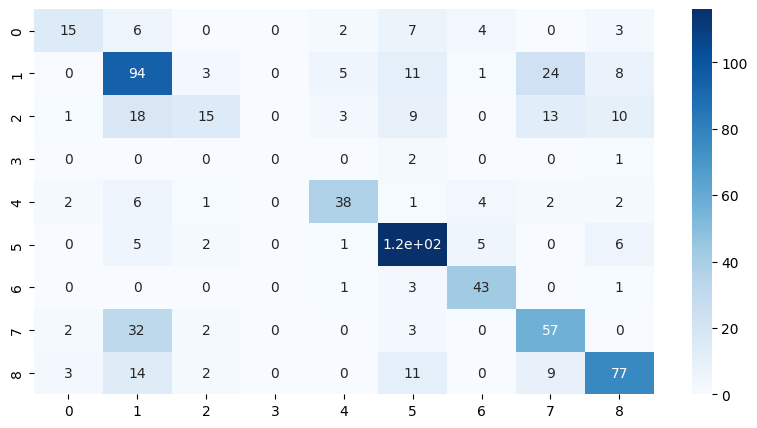

In [56]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, rfc_preds), annot=True, cmap="Blues")
plt.show()

In [57]:
f1_score(y_test, rfc_preds, average="weighted")

0.6300180257835978

In [58]:
accuracy_score(y_test, rfc_preds)

0.6444759206798867